In [1]:
import numpy as np

In [2]:
import scanpy as sc
import umap
import matplotlib.pyplot as plt
from moscot.problems.generic import SinkhornProblem

/root/miniconda3/envs/moscot/lib/python3.10/site-packages/dask/array/chunk_types.py:110: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy, cupy-cuda11x

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  import cupy
/root/miniconda3/envs/moscot/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please 

In [3]:
# 1. PBMC 3 k 데이터 다운로드 및 전처리  (≈ 5 MB)
adata = sc.datasets.pbmc3k()                                   # AnnData 객체 얻기
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=True)
sc.pp.pca(adata, n_comps=50)                                   # adata.obsm['X_pca'] 생성
print(adata)

AnnData object with n_obs × n_vars = 2700 × 2000
    var: 'gene_ids', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'


In [4]:
#2. 두 '도메인' 생성 – 여기서는 간단히 1/2씩 랜덤 분할
np.random.seed(0)
shuffled = np.random.permutation(adata.n_obs)
mid = adata.n_obs // 2
adata.obs['batch'] = np.where(np.isin(np.arange(adata.n_obs), shuffled[:mid]),
                              'd1', 'd2')

In [ ]:
from moscot.problems.generic import SinkhornProblem

# 1) SinkhornProblem 객체 생성
prob = SinkhornProblem(adata)

# 2) prepare 호출: key='batch', joint_attr='X_pca' 로 전달
prob.prepare(
    key='batch',        # obs 컬럼 이름을 지정 (이전의 batch_key)
    joint_attr='X_pca'  # obsm에 저장된 PCA 결과 사용
)

SinkhornProblem[('d1', 'd2')]

In [6]:
# # 3) OT 문제 해결
prob.solve(
    epsilon=1e-3,       # entropic regularization 계수
    rank=50             # 저랭크 근사를 위한 차원 (optional)
)


INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(1350, 1350)].                                          


SinkhornProblem[('d1', 'd2')]

/tmp/ipykernel_89696/372420060.py:21: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=1.0, key_added='leiden')


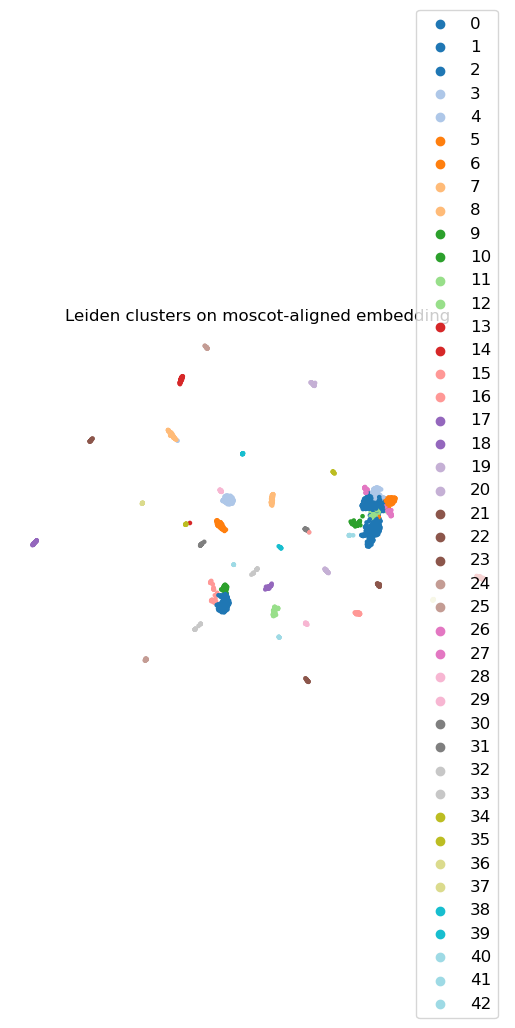

In [7]:
# 4. Barycentric projection (d2 → d1 정렬)
tm = prob.problems[('d1', 'd2')].solution
T  = tm.transport_matrix           # shape (n_d2, n_d1)
X_d1 = adata[adata.obs['batch']=='d1'].obsm['X_pca']
X_d2 = adata[adata.obs['batch']=='d2'].obsm['X_pca']
aligned_d2 = (T @ X_d1) / T.sum(axis=1, keepdims=True)
aligned_d1 = X_d1

# 5. 전체 셀에 대해 'X_moscot' rep 세팅
aligned = np.zeros_like(adata.obsm['X_pca'])
mask_d1 = adata.obs['batch']=='d1'
aligned[mask_d1, :]   = aligned_d1
aligned[~mask_d1, :]  = aligned_d2
adata.obsm['X_moscot'] = aligned

# 6. 이웃 그래프 → UMAP (moscot 임베딩 사용)
sc.pp.neighbors(adata, use_rep='X_moscot', n_neighbors=30)
sc.tl.umap(adata, min_dist=0.3)

# 7. Leiden clustering → 문자열로 변환
sc.tl.leiden(adata, resolution=1.0, key_added='leiden')
adata.obs['leiden_str'] = adata.obs['leiden'].astype(str)

# 8. UMAP 시각화 (discrete palette + 범례)
sc.pl.umap(
    adata,
    color='leiden_str',
    palette='tab20',
    legend_loc='right',
    legend_fontsize=12,
    title='Leiden clusters on moscot-aligned embedding',
    frameon=False,
)

In [7]:
# 4. barycentric projection으로 'd2 → d1' 정렬 가져오기
tm  = prob.problems[('d1', 'd2')].solution                       # transport result
T   = tm.transport_matrix                                        # rows=d2, cols=d1
X_d1 = adata[adata.obs['batch']=='d1'].obsm['X_pca']
X_d2 = adata[adata.obs['batch']=='d2'].obsm['X_pca']

aligned_d2 = (T @ X_d1) / T.sum(axis=1, keepdims=True)           # Barycentric coordinates
aligned_d1 = X_d1                                                # d1은 고정


In [8]:
sc.pp.neighbors(adata_cl, n_neighbors=500, use_rep='X')

for res in [0.1, 0.2, 0.3, 0.5, 0.8]:
    key = f"leiden_{res}"
    sc.tl.leiden(adata, resolution=res, key_added=key)
    n_clusters = adata.obs[key].nunique()
    print(f"resolution={res:>4} ▶ clusters = {n_clusters}")

NameError: name 'adata_cl' is not defined

/root/miniconda3/envs/moscot/lib/python3.10/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
/root/miniconda3/envs/moscot/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


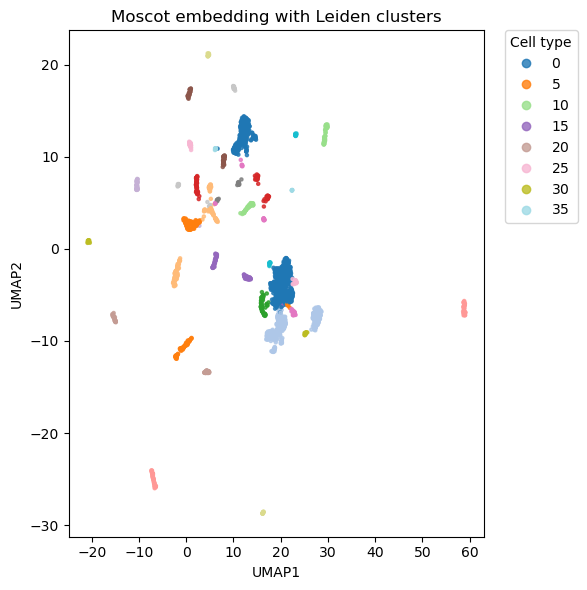

In [10]:
import scanpy as sc
import anndata
import umap
import matplotlib.pyplot as plt
import numpy as np

# --- 1) combined 임베딩 & Leiden 레이블 준비 ---
# aligned_d1, aligned_d2: 앞서 barycentric 투영으로 얻은 두 도메인 임베딩 (numpy array)
combined = np.vstack([aligned_d1, aligned_d2])

# AnnData 생성 → 이웃 그래프 → Leiden 클러스터링
adata_cl = anndata.AnnData(X=combined)
sc.pp.neighbors(adata_cl, n_neighbors=15, use_rep='X')
sc.tl.leiden(adata_cl, resolution=0.5)

# Leiden 레이블 (문자열 → 정수 변환)
labels = adata_cl.obs['leiden'].astype(int).values

# --- 2) UMAP 차원 축소 ---
reducer = umap.UMAP(n_neighbors=15, min_dist=0.5)
umap_emb = reducer.fit_transform(combined)

# --- 3) 시각화: 클러스터별 색상, 범례 자동 생성 ---
fig, ax = plt.subplots(figsize=(6,6))

# 전체 점을 한 번에 그립니다.
scatter = ax.scatter(
    umap_emb[:, 0],
    umap_emb[:, 1],
    c=labels,
    cmap='tab20',
    s=5,
    alpha=0.8
)

# scatter 객체에서 범례 요소 추출
handles, legend_labels = scatter.legend_elements()
legend = ax.legend(
    handles, legend_labels,
    title="Cell type",
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0.
)

ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_title('Moscot embedding with Leiden clusters')

plt.tight_layout()
plt.show()

In [25]:
import cupy as cp
from sklearn.neighbors import NearestNeighbors

def evaluate_embedding_gpu(
    X_hi_cp, Z_low_cp,
    k=30,
    n_pairs=100_000,
    random_state=0
):
    """
    - GPU 상에서 거리 샘플링, Pearson corr, 1D EMD 계산
    - KNN overlap 은 sklearn NearestNeighbors 로 CPU 상에서 계산
    """
    N = X_hi_cp.shape[0]
    rs = cp.random.RandomState(random_state)
    idx = rs.randint(0, N, size=(n_pairs, 2))

    # 1) 샘플링된 거리 계산 (GPU)
    Dx = cp.linalg.norm(
        X_hi_cp[idx[:, 0]] - X_hi_cp[idx[:, 1]], axis=1
    ).astype(cp.float32)
    Dz = cp.linalg.norm(
        Z_low_cp[idx[:, 0]] - Z_low_cp[idx[:, 1]], axis=1
    ).astype(cp.float32)

    # 2) GPU 위에서 Pearson correlation 계산
    x_mean = Dx.mean()
    z_mean = Dz.mean()
    cov    = ((Dx - x_mean) * (Dz - z_mean)).mean()
    std_x  = (Dx - x_mean).std()
    std_z  = (Dz - z_mean).std()
    corr   = cov / (std_x * std_z + 1e-8)

    # 3) 1D EMD via 정렬 (GPU)
    Dx_s = cp.sort(Dx)
    Dz_s = cp.sort(Dz)
    emd  = cp.mean(cp.abs(Dx_s - Dz_s))

    # 4) KNN-overlap (CPU, sklearn)
    X_np = cp.asnumpy(X_hi_cp)
    Z_np = cp.asnumpy(Z_low_cp)

    nn_hi = NearestNeighbors(n_neighbors=k+1).fit(X_np)
    nn_lo = NearestNeighbors(n_neighbors=k+1).fit(Z_np)

    knn_hi = nn_hi.kneighbors(X_np, return_distance=False)[:, 1:]
    knn_lo = nn_lo.kneighbors(Z_np, return_distance=False)[:, 1:]

    overlap = (knn_hi[:, :, None] == knn_lo[:, None, :]).any(-1).mean()

    return {
        'corr':     float(corr),
        'emd':      float(emd),
        'knn_pres': float(overlap)
    }

In [ ]:
# --- 5) embedding 평가 ---

import cupy as cp
from sklearn.metrics import silhouette_score

# 1) GPU 평가를 위한 배열 변환
#    X_hi: 원본 고차원 임베딩 (PCA)
#    Z_low: UMAP 저차원 임베딩
X_hi = adata.obsm['X_pca']         # (n_cells, n_pcs)
Z_low = umap_emb                   # (n_cells, 2)

X_hi_cp = cp.asarray(X_hi, dtype=cp.float32)
Z_low_cp = cp.asarray(Z_low, dtype=cp.float32)

# 2) evaluate_embedding_gpu 호출
metrics = evaluate_embedding_gpu(
    X_hi_cp=X_hi_cp,
    Z_low_cp=Z_low_cp,
    k=30,             # KNN-overlap 계산에 쓸 이웃 개수
    n_pairs=100_000,  # 샘플링할 거리 쌍 수
    random_state=0
)
print("GPU 기반 embedding 평가 결과:")
print(f"  Pearson corr:  {metrics['corr']:.4f}")
print(f"  1D EMD:         {metrics['emd']:.4f}")
print(f"  KNN overlap:   {metrics['knn_pres']:.4f}")

# --- 6) 실루엣 스코어 계산 ---

# Leiden 레이블(labels)은 이미 정수형으로 준비되어 있습니다.
# UMAP 상의 클러스터 구분을 얼마나 잘 보존하는지 평가
sil_score_umap = silhouette_score(Z_low, labels)
print(f"\nSilhouette Score (UMAP embedding): {sil_score_umap:.4f}")

# (선택) PCA 상에서도 한 번 확인해 볼 수 있습니다.
sil_score_pca = silhouette_score(X_hi, labels)
print(f"Silhouette Score (PCA space):     {sil_score_pca:.4f}")

In [ ]:
import numpy as np
from sklearn.neighbors import kneighbors_graph
from scipy.sparse import csgraph, csr_matrix
from scipy.sparse.linalg import eigsh

def compute_spectrum(coords, k=15, r=20):
    """
    Compute the first r+1 eigenvalues of the normalized Laplacian
    of a symmetric, Gaussian‐weighted k-NN graph on coords (array n×d).
    """
    # 1) distance‐based k-NN graph
    D = kneighbors_graph(coords, n_neighbors=k,
                         mode='distance', include_self=False)
    D = 0.5 * (D + D.T)

    # 2) Gaussian kernel weights
    sigma = np.median(D.data)
    W_data = np.exp(- (D.data**2) / (2 * sigma**2 + 1e-16))
    W = csr_matrix((W_data, D.indices, D.indptr), shape=D.shape)
    W = 0.5 * (W + W.T)

    # 3) normalized Laplacian
    L = csgraph.laplacian(W, normed=True)

    # 4) compute smallest r+1 eigenvalues
    m = min(r+1, L.shape[0]-2)
    vals, _ = eigsh(L, k=m, which='SM', tol=1e-3)
    vals = np.sort(vals)
    if vals.shape[0] < r+1:
        vals = np.pad(vals, (0, r+1-vals.shape[0]), constant_values=0)
    return vals

def spectral_graph_concordance(vals_nat, vals_lat, r=20):
    """
    Compute SGC(r) = 1 - sum_i|λ_nat_i - λ_lat_i| / sum_i λ_nat_i,
    clipped to [0,1].
    """
    diff = np.abs(vals_nat[1:r+1] - vals_lat[1:r+1]).sum()
    denom = vals_nat[1:r+1].sum()
    if denom <= 0:
        return 0.0
    return float(np.clip(1 - diff/denom, 0.0, 1.0))

# --- 1) Native spectra for each domain from PCA coordinates ---
# X_d1, X_d2 defined earlier as:
#    X_d1 = adata[adata.obs['batch']=='d1'].obsm['X_pca']
#    X_d2 = adata[adata.obs['batch']=='d2'].obsm['X_pca']
k, r = 15, 20
vals_nat1 = compute_spectrum(X_d1, k=k, r=r)
vals_nat2 = compute_spectrum(X_d2, k=k, r=r)

# --- 2) Split the UMAP embedding back into domains ---
# umap_emb from your code: shape (n1+n2, 2)
n1 = X_d1.shape[0]
emb1 = umap_emb[:n1]
emb2 = umap_emb[n1:]

# --- 3) Latent spectra on UMAP coords ---
vals_lat1 = compute_spectrum(emb1, k=k, r=r)
vals_lat2 = compute_spectrum(emb2, k=k, r=r)

# --- 4) Compute SGC for each domain ---
sgc1 = spectral_graph_concordance(vals_nat1, vals_lat1, r=r)
sgc2 = spectral_graph_concordance(vals_nat2, vals_lat2, r=r)

print(f"Domain1 SGC (r={r}, k={k}): {sgc1:.3f}")
print(f"Domain2 SGC (r={r}, k={k}): {sgc2:.3f}")
